In [3]:
from datasets import load_dataset, ClassLabel, Dataset
from evaluate import load
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast, DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, AutoTokenizer, TrainingArguments, Trainer, pipeline

In [4]:
# Load the CoNLL-2003 dataset
dataset = load_dataset("conll2003",trust_remote_code=True)
print(dataset)

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [42]:
def tokenize_and_align_labels(dataset, label_all_tokens=True):

    tokenized_inputs = tokenizer(dataset["tokens"], truncation=True, is_split_into_words=True, padding="max_length", max_length=128)
    labels = []
    for i, label in enumerate(dataset["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [6]:
dataset = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [7]:
# Define the label map
label_list = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# Load pre-trained BERT model
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(label_list))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
args = TrainingArguments(
"test-ner",
evaluation_strategy = "epoch",
logging_strategy="epoch",
learning_rate=2e-5,
per_device_train_batch_size=16,
per_device_eval_batch_size=16,
num_train_epochs=3,
weight_decay=0.01,
)
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load("seqeval")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
def compute_metrics(eval_preds):

    pred_logits, labels = eval_preds

    pred_logits = np.argmax(pred_logits, axis=2)

    predictions = [
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(pred_logits, labels)
    ]

    true_labels = [
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100]
       for prediction, label in zip(pred_logits, labels)
   ]
    results = metric.compute(predictions=predictions, references=true_labels)
    return {
   "precision": results["overall_precision"],
   "recall": results["overall_recall"],
   "f1": results["overall_f1"],
  "accuracy": results["overall_accuracy"],
  }

In [10]:
trainer = Trainer(
    model,
    args,
   train_dataset=dataset["train"],
   eval_dataset=dataset["validation"],
   data_collator=data_collator,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics
)
trainer.train()

<ipython-input-10-a0ba19aafa89>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yacine-aitkaci (yacine-aitkaci-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.156500,0.065105,0.917091,0.926837,0.921938,0.982191
2,0.043700,0.059543,0.932890,0.942387,0.937615,0.985194
3,0.025500,0.058648,0.936302,0.945520,0.940888,0.985893


TrainOutput(global_step=2634, training_loss=0.07525425348303584, metrics={'train_runtime': 541.6765, 'train_samples_per_second': 77.764, 'train_steps_per_second': 4.863, 'total_flos': 1020143109346326.0, 'train_loss': 0.07525425348303584, 'epoch': 3.0})

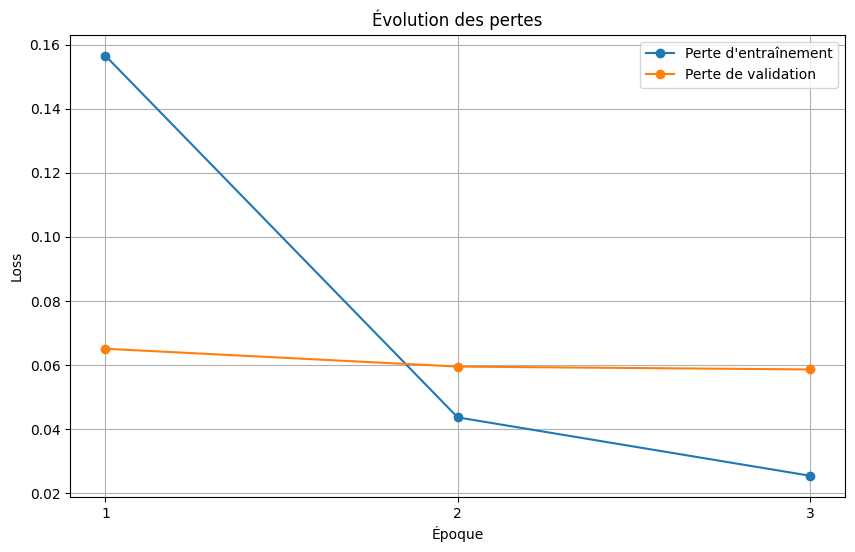

In [11]:
log_history = trainer.state.log_history

train_losses = [log['loss'] for log in log_history if 'loss' in log]
eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]

plt.figure(figsize=(10, 6))
plt.plot(train_losses, marker='o', label='Perte d\'entraînement')
plt.plot(eval_losses, marker='o', label='Perte de validation')
plt.title('Évolution des pertes')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.xticks(range(len(train_losses)), range(1, len(train_losses)+1))
plt.grid(True)
plt.legend()
plt.show()

In [12]:
model.save_pretrained("general_ner_model")
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [13]:
id2label = {
    str(i): label for i,label in enumerate(label_list)
}
label2id = {
    label: str(i) for i,label in enumerate(label_list)
}

config = json.load(open("general_ner_model/config.json"))
config["id2label"] = id2label
config["label2id"] = label2id
json.dump(config, open("general_ner_model/config.json","w"))

In [14]:
model_fine_tuned = AutoModelForTokenClassification.from_pretrained("general_ner_model")

In [15]:
nlp = pipeline("ner", model=model_fine_tuned, tokenizer=tokenizer,  aggregation_strategy="none")

example = "Bill Gates is the Founder of Microsoft"

ner_results = nlp(example)

print(ner_results)


Device set to use cuda:0


[{'entity': 'B-PER', 'score': 0.9934949, 'index': 1, 'word': 'bill', 'start': 0, 'end': 4}, {'entity': 'I-PER', 'score': 0.9934323, 'index': 2, 'word': 'gates', 'start': 5, 'end': 10}, {'entity': 'B-ORG', 'score': 0.98159343, 'index': 7, 'word': 'microsoft', 'start': 29, 'end': 38}]


In [ ]:
# Define the path to the directory containing the JSON files
directory_path = "ResumesJsonAnnotated/"

# Load all JSON files
data = []
for filename in os.listdir(directory_path):
    if filename.endswith(".json"):
        with open(os.path.join(directory_path, filename), "r") as file:
            data.append(json.load(file))

# Example of accessing the first CV's text and annotations
first_cv = data[0]
text = first_cv['text']
annotations = first_cv['annotations']

print(f"Text: {text}")
print(f"Annotations: {annotations}")

In [18]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()
#stop_words = set(stopwords.words('english'))

def nettoyer(text):
    text = text.lower()
    # Supprimer les caractères spéciaux
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenisation
    words = nltk.word_tokenize(text)
    # Suppression des mots vides et lemmatisation
    words = [lemmatizer.lemmatize(word) for word in words ]
    # Reconstituer le texte prétraité
    return words

for entry in data:
    entry['text'] = nettoyer(entry['text'])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [56]:
def convert_to_annotations(cleaned_tokens, annotations):

    labels = ["O"] * len(cleaned_tokens)
    for ann in annotations:
        skill_phrase = ann[2].split(":")[-1].strip()
        cleaned_skill_tokens = nettoyer(skill_phrase)
        if not cleaned_skill_tokens:
            continue

        for i in range(len(cleaned_tokens) - len(cleaned_skill_tokens) + 1):
            if cleaned_tokens[i:i+len(cleaned_skill_tokens)] == cleaned_skill_tokens:
                labels[i] = "B-SKILL"
                for j in range(1, len(cleaned_skill_tokens)):
                    if i + j < len(labels):
                        labels[i + j] = "I-SKILL"
                break


    for i in range(1, len(cleaned_tokens)):
        if cleaned_tokens[i] in ["work", "is"]:
            labels[i] = "O"
        if (cleaned_tokens[i-1] == "data" and
            cleaned_tokens[i] in ["scientist", "analyst"]):
            labels[i] = "I-SKILL"
            if labels[i-1] == "O":
                labels[i-1] = "B-SKILL"

    return cleaned_tokens, labels

In [57]:
def process_dataset(entries, output_file):
    with open(output_file, "w", encoding="utf-8") as out_file:
        for entry in entries:
            cleaned_tokens = entry["text"]
            annotations = entry["annotations"]

            tokens, labels = convert_to_annotations(cleaned_tokens, annotations)

            filtered_tokens = []
            filtered_labels = []
            for token, label in zip(tokens, labels):
                if len(token) > 1:
                    filtered_tokens.append(token)
                    filtered_labels.append(label)

            for token, label in zip(filtered_tokens, filtered_labels):
                out_file.write(f"{token} {label}\n")
            out_file.write("\n")
    print(f"Processed data saved to {output_file}")

output_file = "output.conll"
process_dataset(data, output_file)

Processed data saved to output.conll


In [39]:
def load_conll_file(conll_path):

    entries = []
    current_tokens = []
    current_labels = []

    with open(conll_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if current_tokens:
                    entries.append({"tokens": current_tokens, "labels": current_labels})
                    current_tokens = []
                    current_labels = []
                continue

            parts = line.split()
            if len(parts) >= 2:
                token, label = parts[0], parts[1]
                current_tokens.append(token)
                current_labels.append(label)

    return entries

In [40]:
def align_predictions(tokens, predictions, tokenizer=tokenizer):

    aligned_labels = ["O"] * len(tokens)

    mapping = []
    for token in tokens:
        subwords = tokenizer.tokenize(token)
        mapping.append((token, subwords))

    pred_idx = 0
    for token_idx, (orig_token, subwords) in enumerate(mapping):
        if not subwords or pred_idx >= len(predictions):
            continue

        for sw in subwords:
            if pred_idx >= len(predictions):
                break

            label = predictions[pred_idx].get("entity_group") or predictions[pred_idx].get("entity", "O")

            if sw.strip("##") == predictions[pred_idx]["word"].strip("##"):
                if aligned_labels[token_idx] == "O":
                    aligned_labels[token_idx] = label
                pred_idx += 1

    return aligned_labels

In [41]:
def process_conll_with_predictions(input_conll, output_conll):

    entries = load_conll_file(input_conll)
    with open(output_conll, "w", encoding="utf-8") as f:
        for entry in entries:
            tokens = entry["tokens"]
            original_labels = entry["labels"]

            text = " ".join(tokens).replace(" ##", "")
            predictions = nlp(text)
            new_labels = align_predictions(tokens, predictions)
            final_labels = []

            for token, old_label, new_label in zip(tokens, original_labels, new_labels):
                if "MISC" in new_label:
                    final_label = new_label if old_label == "O" else old_label

                elif new_label != "O":
                    final_label = new_label
                else:
                    final_label = old_label

                if len(token) > 1:
                    final_labels.append((token, final_label))

            for token, label in final_labels:
                f.write(f"{token} {label}\n")
            f.write("\n")

    print(f"Updated predictions saved to {output_conll}")

input_file = "output.conll"
output_file = "final_output.conll"
process_conll_with_predictions(input_file, output_file)

Updated predictions saved to final_output.conll


In [43]:
# Define the label map
label_list = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC','B-SKILL', 'I-SKILL']
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}


In [44]:
def load_conll_file(file_path):
    tokens = []
    ner_tags = []
    current_tokens = []
    current_labels = []

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if current_tokens:
                    tokens.append(current_tokens)
                    ner_tags.append(current_labels)
                    current_tokens = []
                    current_labels = []
                continue

            parts = line.split()
            if len(parts) >= 2:
                current_tokens.append(parts[0])
                current_labels.append(label2id[parts[1]])

    return {"tokens": tokens, "ner_tags": ner_tags}

# Convert CoNLL to dataset
conll_data = load_conll_file("final_output.conll")
dataset = Dataset.from_dict(conll_data)


In [45]:
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset.column_names
)

Map:   0%|          | 0/4981 [00:00<?, ? examples/s]

In [46]:
# Split dataset
split_dataset = tokenized_dataset.train_test_split(test_size=0.1)

In [47]:
model = AutoModelForTokenClassification.from_pretrained(
    "/content/general_ner_model",
    num_labels=len(label_list),
         label2id = {
        label: i for i, label in enumerate(label_list)
        },
        id2label = {
         i: label for i, label in enumerate(label_list)
         },
        ignore_mismatched_sizes=True

)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at /content/general_ner_model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([11]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
)
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load("seqeval")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [49]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()

<ipython-input-49-9240f1d47331>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.524500,0.316393,0.767330,0.787216,0.777145,0.886124
2,0.277200,0.254323,0.804994,0.837108,0.820737,0.909804
3,0.205000,0.207905,0.858903,0.860524,0.859713,0.930966
4,0.165100,0.200045,0.857157,0.881339,0.869080,0.934365
5,0.138400,0.200898,0.863379,0.879808,0.871516,0.936946
6,0.123400,0.198402,0.866191,0.886032,0.875999,0.938693


TrainOutput(global_step=846, training_loss=0.23894404914080392, metrics={'train_runtime': 888.6776, 'train_samples_per_second': 30.261, 'train_steps_per_second': 0.952, 'total_flos': 1756841035336704.0, 'train_loss': 0.23894404914080392, 'epoch': 6.0})

In [50]:
model.save_pretrained("./final_model")
tokenizer.save_pretrained("./final_model")

('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/vocab.txt',
 './final_model/added_tokens.json',
 './final_model/tokenizer.json')

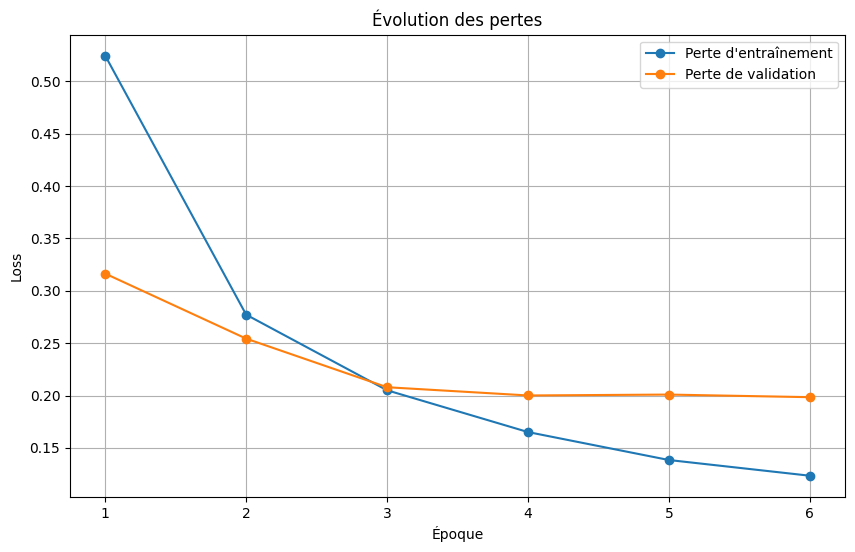

In [51]:
log_history = trainer.state.log_history

train_losses = [log['loss'] for log in log_history if 'loss' in log]
eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]

plt.figure(figsize=(10, 6))
plt.plot(train_losses, marker='o', label='Perte d\'entraînement')
plt.plot(eval_losses, marker='o', label='Perte de validation')
plt.title('Évolution des pertes')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.xticks(range(len(train_losses)), range(1, len(train_losses)+1))
plt.grid(True)
plt.legend()
plt.show()

In [55]:
sample_text = "John works at Google in Paris and is a data analyst."
sample_text2 = "Expert in Python and Java, worked at Facebook in NEW YORK."
ner_pipeline = pipeline("ner", model="/content/final_model", tokenizer=tokenizer)
print(ner_pipeline(sample_text))
print(ner_pipeline(sample_text2))

Device set to use cuda:0


[{'entity': 'B-PER', 'score': 0.9917149, 'index': 1, 'word': 'john', 'start': 0, 'end': 4}, {'entity': 'B-ORG', 'score': 0.99571264, 'index': 4, 'word': 'google', 'start': 14, 'end': 20}, {'entity': 'B-LOC', 'score': 0.9954863, 'index': 6, 'word': 'paris', 'start': 24, 'end': 29}, {'entity': 'B-SKILL', 'score': 0.98265517, 'index': 10, 'word': 'data', 'start': 39, 'end': 43}, {'entity': 'I-SKILL', 'score': 0.9163737, 'index': 11, 'word': 'analyst', 'start': 44, 'end': 51}]
[{'entity': 'B-SKILL', 'score': 0.88308007, 'index': 3, 'word': 'python', 'start': 10, 'end': 16}, {'entity': 'B-SKILL', 'score': 0.92504615, 'index': 5, 'word': 'java', 'start': 21, 'end': 25}, {'entity': 'B-ORG', 'score': 0.995565, 'index': 9, 'word': 'facebook', 'start': 37, 'end': 45}, {'entity': 'B-LOC', 'score': 0.99659216, 'index': 11, 'word': 'new', 'start': 49, 'end': 52}, {'entity': 'I-LOC', 'score': 0.9912476, 'index': 12, 'word': 'york', 'start': 53, 'end': 57}]
